# TIFO & IMED final project

functions :
- [x] read image and predictions 
- [x] first prediction
- [ ] score function
- [ ] improve skeleton exctraction
- [ ] handle problematic cases : lateral bar, loss of dark gray hole during global thresholding

### Imports

In [1]:
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelmax, argrelmin
from skimage.morphology import binary_opening, binary_closing, disk, skeletonize
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Utility functions

In [2]:
def read_img(img_file):
    img = cv2.imread(img_file)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_gray

In [3]:
def plot_pred(img, pred):
    plt.imshow(img, cmap='gray')
    plt.scatter(pred.x, pred.y)

In [4]:
img = read_img('data/ex04.jpg')
true = pd.read_csv('data/ex04.csv', names=['y', 'x'])

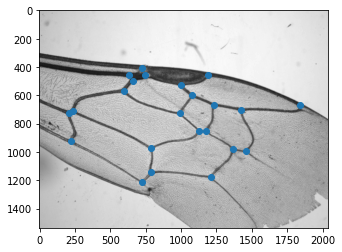

In [5]:
plot_pred(img, true)

In [6]:
# TODO : add legend + titles

def adaptive_global_thresholding(img):
    
    # Downsize image to speedup computations
    scale_percent = 0.1
    width = int(img.shape[1] * scale_percent)
    height = int(img.shape[0] * scale_percent)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

    # Estimate the density of the image histogram
    X = resized.flatten().reshape((-1, 1))
    X_plot = np.linspace(0, 255, 1000)[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(X)
    log_dens = kde.score_samples(X_plot)

    # Find the peaks and valleys of the signal
    peak_i = argrelmax(np.exp(log_dens))
    #valley_i = argrelmin(np.exp(log_dens))

    # Find the beginning of the second peak by checking gradient deviation after first peak
    peak0 = peak_i[0][0]
    grad = np.gradient(np.exp(log_dens))
    std = np.std(grad[peak0:])
    mean = np.mean(grad[peak0:])
    threshold_i = np.argwhere(grad[peak0:] >= mean + 0.09*std)[0, 0] + peak0  # shift to global index by adding peak0

    threshold = X_plot[threshold_i, 0]
    print(f'Threshold: {threshold}')

    plt.figure(figsize=(30, 5))
    
    plt.subplot(141)
    plt.imshow(img, cmap='gray')
    
    plt.subplot(142)
    plt.plot(X_plot[:, 0], grad)
    #plt.scatter(X_plot[peak0], grad[peak0], fc='#00ff00')
    plt.scatter(X_plot[threshold_i], grad[threshold_i], fc='#ff0000')

    plt.subplot(143)
    plt.plot(X_plot[:threshold_i, 0], np.exp(log_dens)[:threshold_i], '#ff8c00',
             X_plot[threshold_i:, 0], np.exp(log_dens)[threshold_i:], '#0073ff')
    plt.scatter(X_plot[peak0], np.exp(log_dens)[peak0], fc='#00ff00')
    plt.scatter(X_plot[threshold_i], np.exp(log_dens)[threshold_i], fc='#ff0000')

    plt.subplot(144)
    filtered = img.copy()
    filtered[img > threshold] = 0
    filtered[img <= threshold] = 255
    plt.imshow(filtered, cmap='gray')

    return filtered

Threshold: 121.24624624624626


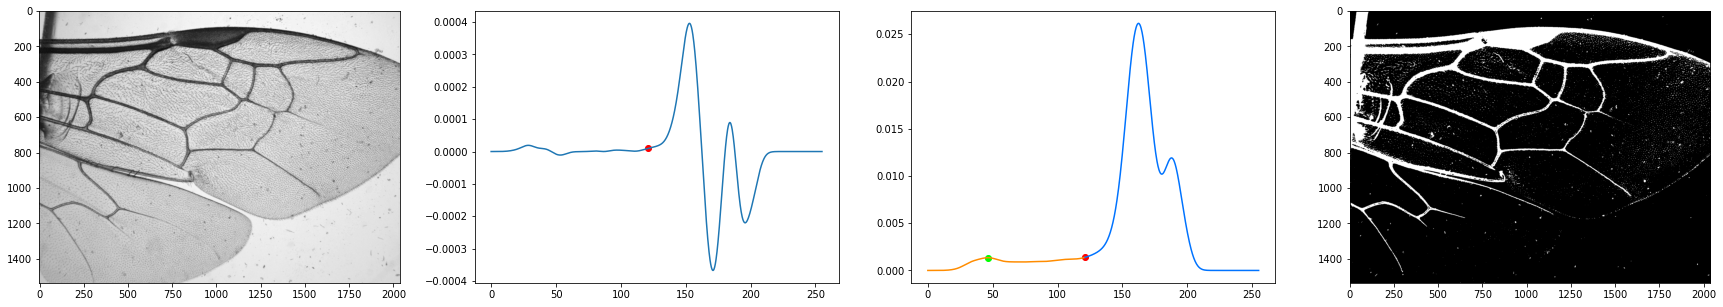

In [7]:
img = read_img('data/ex02.jpg')
filtered = adaptive_global_thresholding(img)

### Extract veins

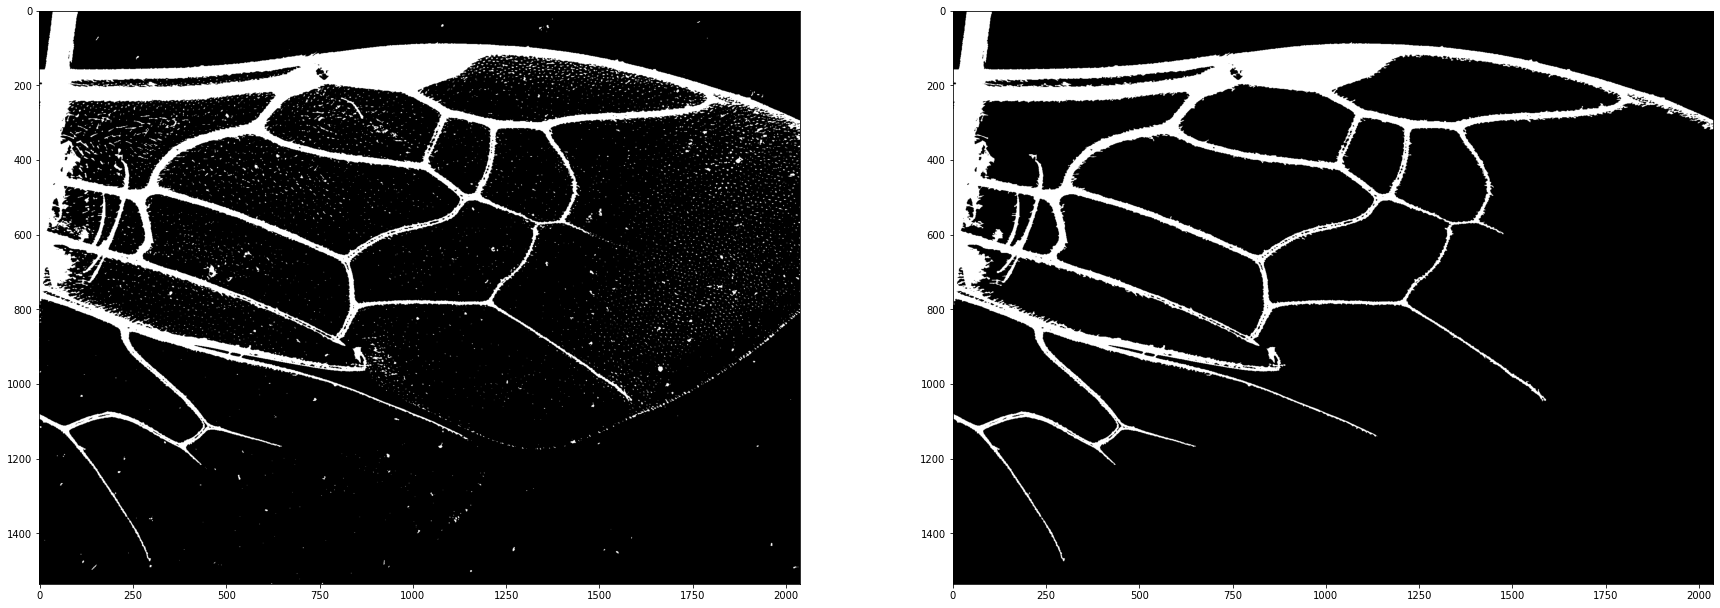

In [8]:
_, labels, stats, centroids = cv2.connectedComponentsWithStats(filtered)
veins = np.zeros(filtered.shape)
label = np.argsort(stats[:, cv2.CC_STAT_AREA])[-2]  # take second largest component (after background)
veins[labels == label] = 255

plt.figure(figsize=(30,30))

plt.subplot(121)
plt.imshow(filtered, cmap='gray')

plt.subplot(122)
plt.imshow(veins, cmap='gray')

### Filter and extract veins skeleton

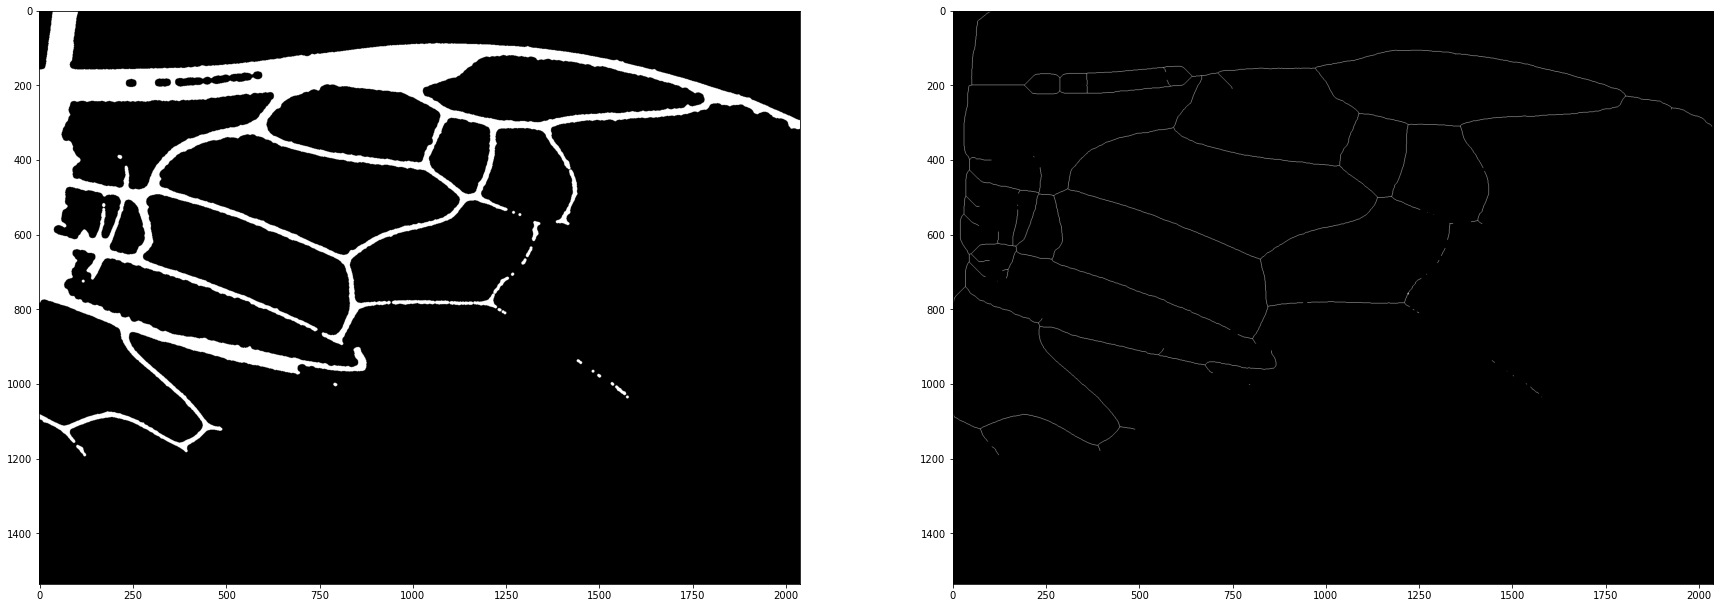

In [9]:
veins2 = veins
veins2 = binary_opening(veins2, disk(2))
veins2 = binary_closing(veins2, disk(10))
veins2 = binary_opening(veins2, disk(4))
#veins2 = binary_opening(veins2, disk(2))
skel = skeletonize(veins2).astype(np.uint8)

plt.figure(figsize=(30,30))

plt.subplot(121)
plt.imshow(veins2, cmap='gray')

plt.subplot(122)
plt.imshow(skel, cmap='gray')

### Detect corners 

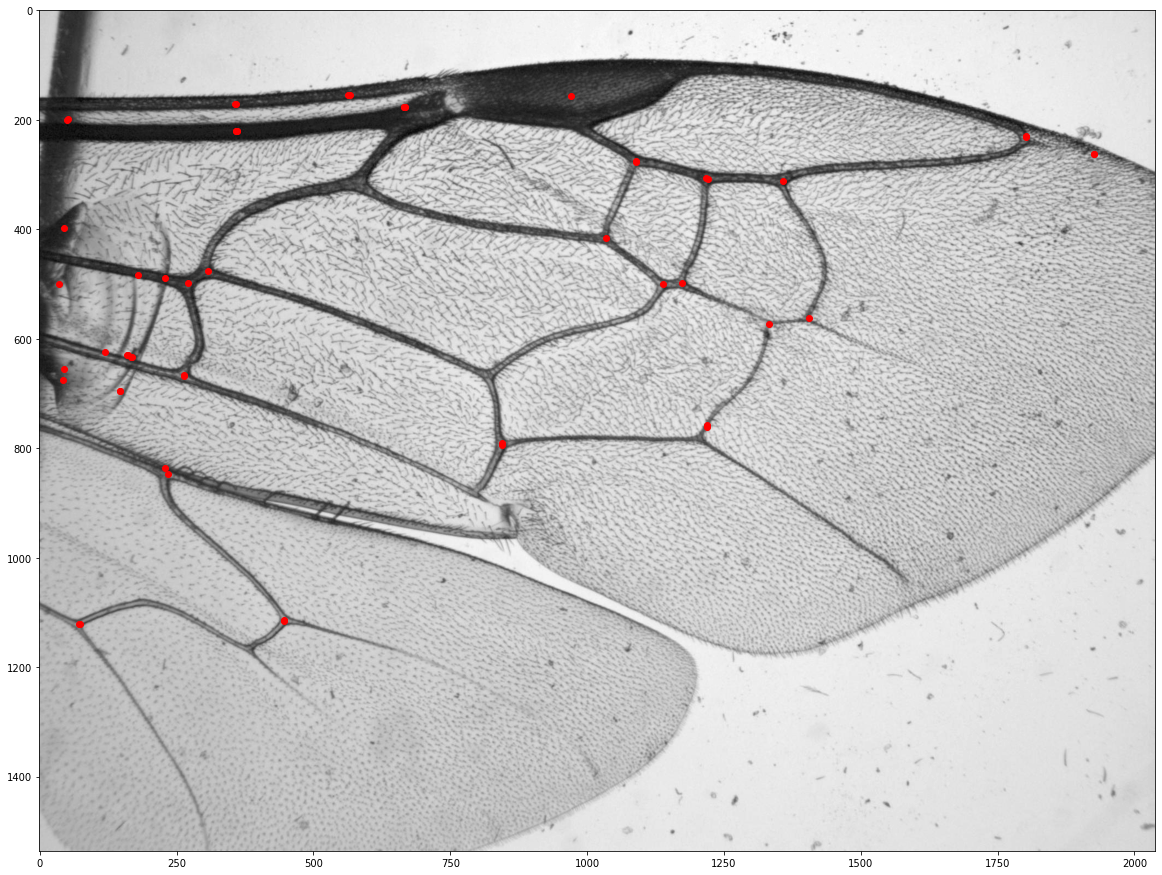

In [10]:
corners = cv2.cornerHarris(skel, 2, 3, 0.04)
corners_coords = np.argwhere(corners > 0.4*corners.max())

plt.figure(figsize=(20, 20))
plt.imshow(img, cmap='gray')
plt.scatter(corners_coords[:, 1], corners_coords[:, 0], fc='#ff0000')